### QC+ for Cai 2020 dataset

#### Objective: Run advanced QC for the Cai 2020 dataset, including data normalization, log transformation, and UMAP visualization


**Developed by**: Mairi McClean

**Affiliation**: Institute of Computational Biology - Computational Health Centre - Helmholtz Munich

**v221130**


### Load modules

In [2]:
import anndata
import logging
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sb
import scrublet as scr
import matplotlib.pyplot as plt
import igraph as ig
from matplotlib import colors
from matplotlib import rcParams

#### Log file and figure output settings

In [3]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 160, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'svg')

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                 9.2.0
appnope             0.1.3
asttokens           NA
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
cffi                1.15.1
colorama            0.4.6
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.3
decorator           5.1.1
entrypoints         0.4
executing           1.1.1
google              NA
h5py                3.6.0
hypergeom_ufunc     NA
igraph              0.10.2
ipykernel           6.16.2
ipywidgets          8.0.2
jedi                0.18.1
joblib              1.2.0
kiwisolver          1.4.4
leidenalg           0.9.0
llvmlite            0.39.1
louvain             0.8.0
matplotlib          3.6.1
mpl_toolkits        NA
natsort             8.2.0
nbinom_ufunc        NA
ncf_ufunc           NA
numba               0.56.3
numexpr             2.8.1
numpy               1.23.4
packaging           21.3
pandas              1.5.1
parso       

### Read in anndata object

In [4]:
adata = sc.read_h5ad('/Users/mairi.mcclean/github/data/tb_pbmc_datasets/qcd_objects/0512_0912_exported_objects/06/CaiY2022_TB_PFMC_QCed_pre-process_mm221206.h5ad')
adata

AnnData object with n_obs × n_vars = 41143 × 61533
    obs: 'study', 'individual', 'sample', 'tissue', 'donor', 'data_type', 'centre', 'version', 'object', 'protocol', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'predicted_doublets'
    var: 'gene_id', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'donor_colors', 'sample_colors', 'tissue_colors'
    layers: 'counts', 'sqrt_norm'

### Data normalization

target_sum taken from Scanpy tutorial [https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html]

If exclude_highly_expressed=True, very highly expressed genes are excluded from the computation of the normalization factor (size factor) for each cell. 
> This is meaningful as these can strongly influence the resulting normalized values for all other genes [Weinreb17]."

1e4 changed to 1e6; option to exclude highly expressed genes, set as true - CHANGE THIS FIRST before changing any other variable to observe effects on PCA output


In [5]:
sc.pp.normalize_total(adata, target_sum=1e6, exclude_highly_expressed=True)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
[]
    finished (0:00:00)


### Data log transformation

In [6]:
sc.pp.log1p(adata)

### Identify highly variable genes

Code from Carlos' notebook scVI_exploratory_analysis; Seurat should be used for all generative models
Number of genes (top_genes) based on how mixed the sample is, and computational power. Highest gene number is 10,000
Batch_key is related to the data that we want to perform the filtering on
Carlos runs between 4000 (low RAM) and 7000
subset = True will remove all non-variable genes

In [7]:
sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 8000,
    layer = "counts",
    batch_key = "sample",
    subset = True
)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [8]:
adata.var.head()


gene_id     mt   ribo  n_cells_by_counts  \
DDX11L1           ENSG00000223972.5  False  False                  5   
ENSG00000238009   ENSG00000238009.6  False  False                 31   
ENSG00000228463  ENSG00000228463.10  False  False                 55   
ENSG00000286448   ENSG00000286448.1  False  False                  8   
ENSG00000230021  ENSG00000230021.10  False  False               8555   

                 mean_counts  pct_dropout_by_counts  total_counts  \
DDX11L1             0.000122              99.987847           5.0   
ENSG00000238009     0.000753              99.924653          31.0   
ENSG00000228463     0.001507              99.866320          62.0   
ENSG00000286448     0.000194              99.980556           8.0   
ENSG00000230021     0.252534              79.206669       10390.0   

                 highly_variable  highly_variable_rank     means  variances  \
DDX11L1                     True                 850.0  0.000930   0.007147   
ENSG00000238009             True                2600.0  0.005820   0.045107   
ENSG00000228463             True                2488.0  0.010260   0.079183   
ENSG00000286448             True                 754.0  0.001494   0.011527   
ENSG00000230021             True                 202.0  1.636854  10.273725   

                 variances_norm  highly_variable_nbatches  
DDX11L1                0.497340                         1  
ENSG00000238009        1.003692                         2  
ENSG00000228463        1.001058                         1  
ENSG00000286448        0.509249                         1  
ENSG00000230021        1.165079                         5

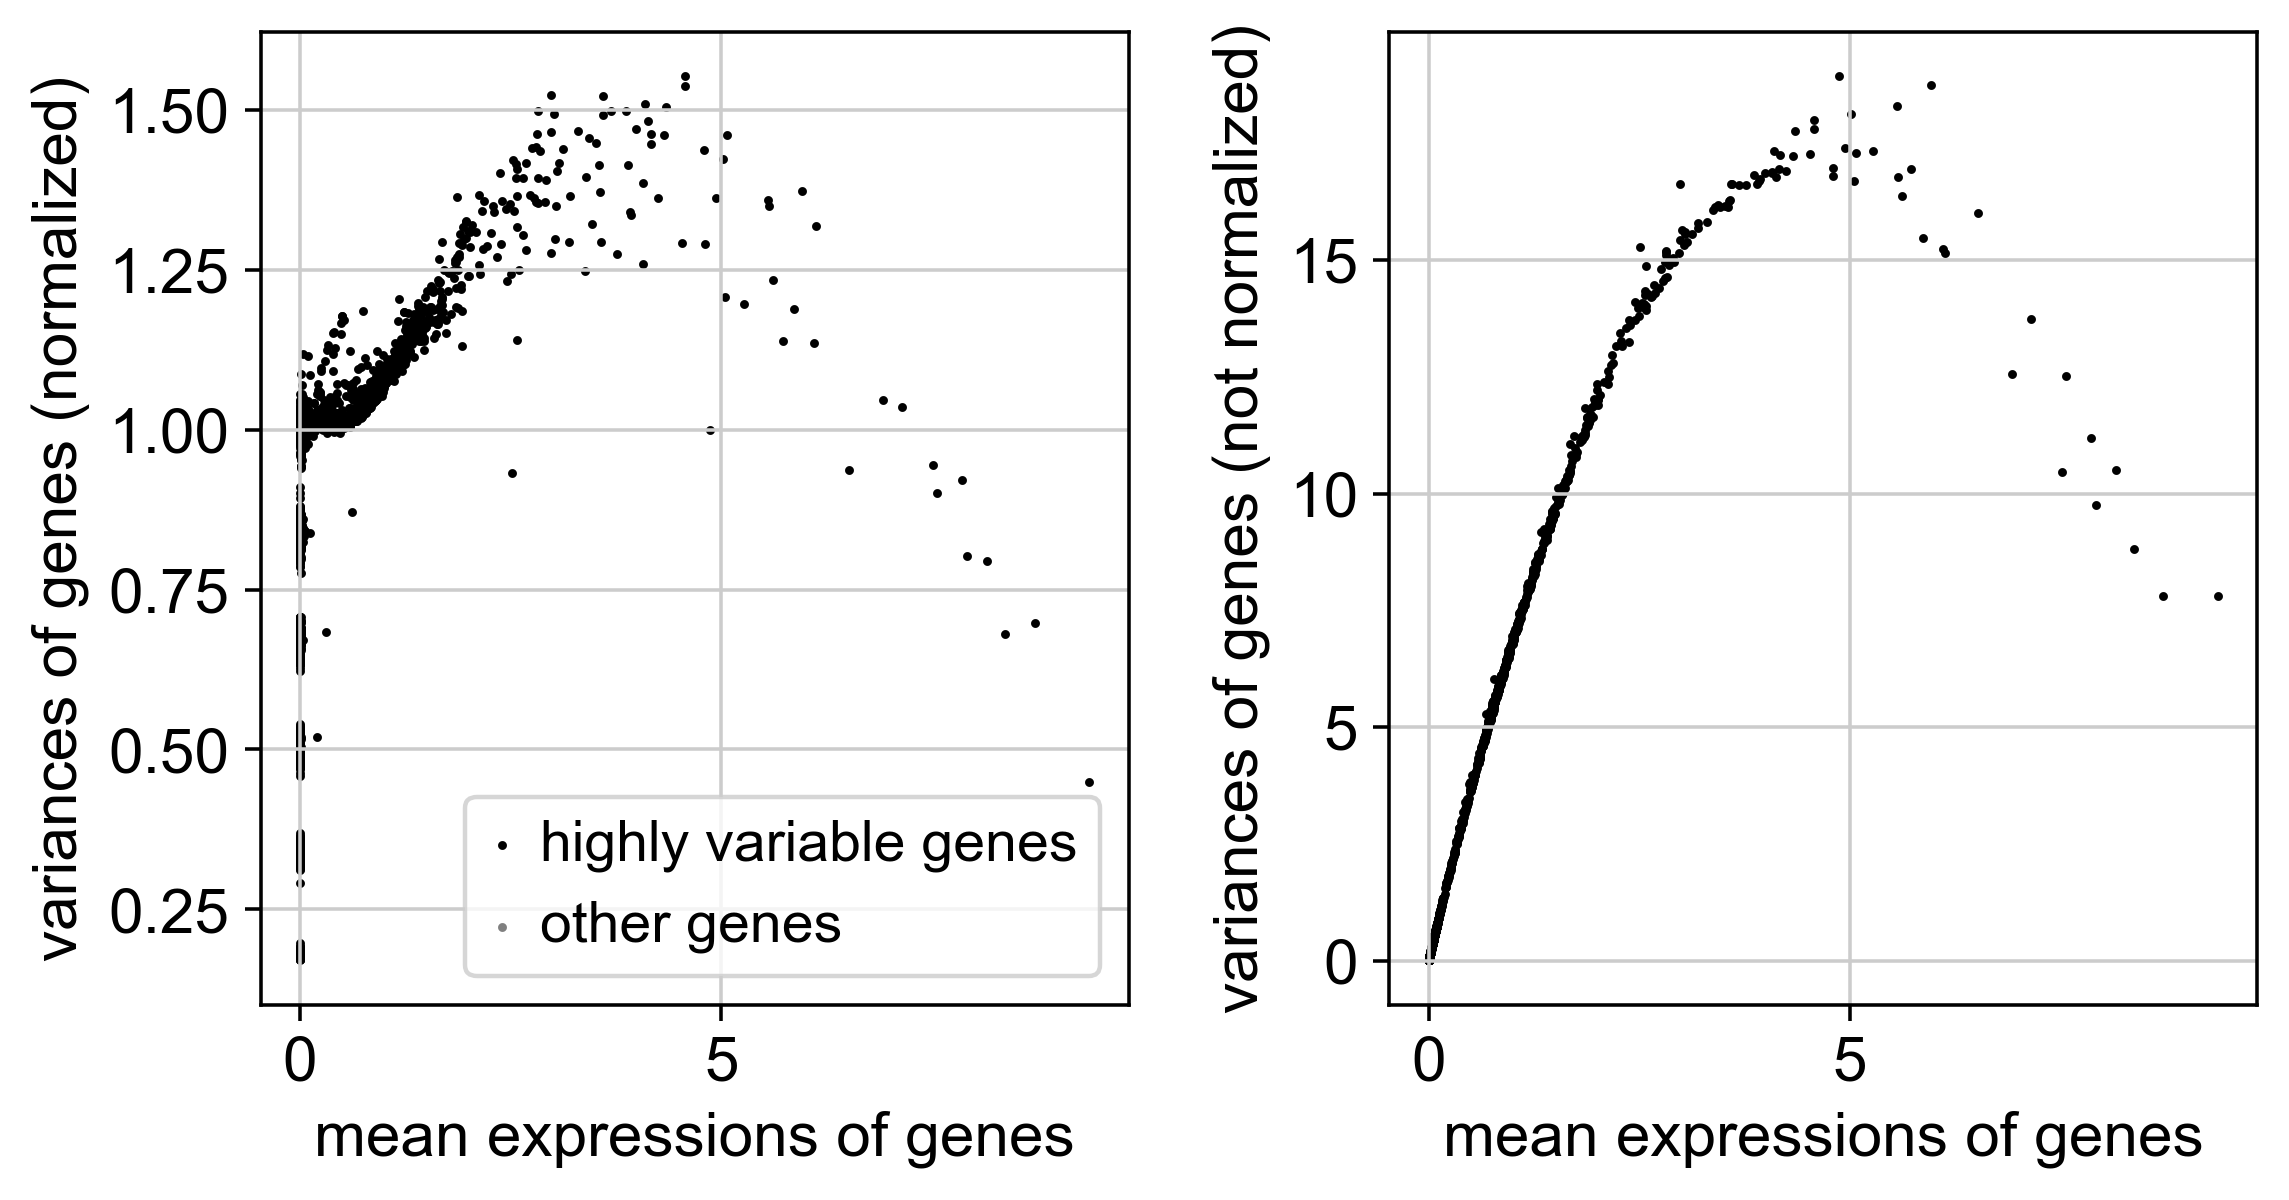

In [9]:
sc.pl.highly_variable_genes(adata)


We want to see between 0.25 and 0.75 after 1
This particular pattern either means that the data is garbage or that it is highly significant, caused by disease
Could see if changing the number of genes from between 4000 to 7000

### PCA

In [10]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)


In [11]:
adata

AnnData object with n_obs × n_vars = 41143 × 8000
    obs: 'study', 'individual', 'sample', 'tissue', 'donor', 'data_type', 'centre', 'version', 'object', 'protocol', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'predicted_doublets'
    var: 'gene_id', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'donor_colors', 'sample_colors', 'tissue_colors', 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'sqrt_norm'

Can add covariates here below; can remove frames from image

/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


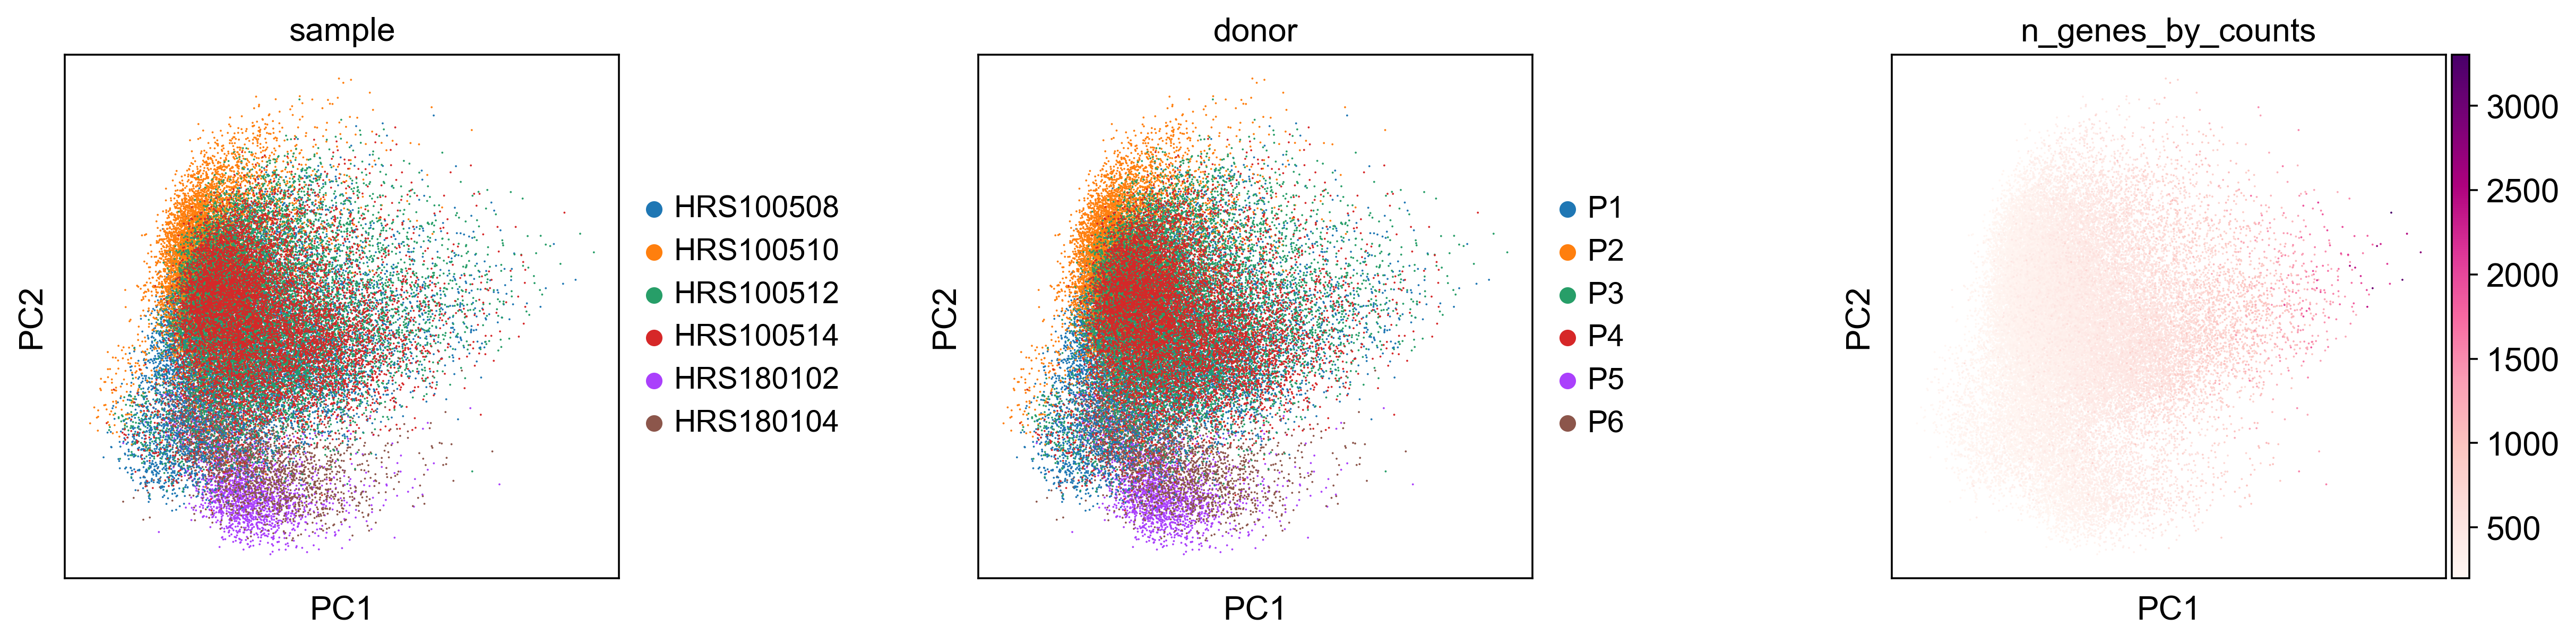

In [12]:
sc.pl.pca(adata, color = ['sample', 'donor', 'n_genes_by_counts'], wspace=0.5)

### Computing neighbourhood graph

Carlos chooses 50 neighbours, and 50 PCs (PCs used to be taken from elbow graph)

This step is done to create a 'scaffold' of the data; UMAP embedding will then place data over scaffold to see how it fits

In [13]:
sc.pp.neighbors(adata, n_neighbors=50, n_pcs=50)



computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:14)


### UMAP embedding

#### Clustering

In [14]:
# added to avoid error arising from running subsequent cell on its own

sc.tl.leiden(adata)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:14)


In [15]:
sc.tl.umap(adata)


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:24)


In [16]:
adata.var.head()


gene_id     mt   ribo  n_cells_by_counts  \
DDX11L1           ENSG00000223972.5  False  False                  5   
ENSG00000238009   ENSG00000238009.6  False  False                 31   
ENSG00000228463  ENSG00000228463.10  False  False                 55   
ENSG00000286448   ENSG00000286448.1  False  False                  8   
ENSG00000230021  ENSG00000230021.10  False  False               8555   

                 mean_counts  pct_dropout_by_counts  total_counts  \
DDX11L1             0.000122              99.987847           5.0   
ENSG00000238009     0.000753              99.924653          31.0   
ENSG00000228463     0.001507              99.866320          62.0   
ENSG00000286448     0.000194              99.980556           8.0   
ENSG00000230021     0.252534              79.206669       10390.0   

                 highly_variable  highly_variable_rank     means  variances  \
DDX11L1                     True                 850.0  0.000930   0.007147   
ENSG00000238009             True                2600.0  0.005820   0.045107   
ENSG00000228463             True                2488.0  0.010260   0.079183   
ENSG00000286448             True                 754.0  0.001494   0.011527   
ENSG00000230021             True                 202.0  1.636854  10.273725   

                 variances_norm  highly_variable_nbatches  
DDX11L1                0.497340                         1  
ENSG00000238009        1.003692                         2  
ENSG00000228463        1.001058                         1  
ENSG00000286448        0.509249                         1  
ENSG00000230021        1.165079                         5

In [17]:
adata.obs.head()

study individual     sample  \
barcode                                                                     
AAACCTGAGAACAATC-HRS180102-pfmc_scRNAseq  CaiY_2022  HRI111687  HRS180102   
AAACCTGAGGTCATCT-HRS180102-pfmc_scRNAseq  CaiY_2022  HRI111687  HRS180102   
AAACCTGTCTTACCTA-HRS180102-pfmc_scRNAseq  CaiY_2022  HRI111687  HRS180102   
AAACGGGGTTTAGGAA-HRS180102-pfmc_scRNAseq  CaiY_2022  HRI111687  HRS180102   
AAAGATGCAATAGCAA-HRS180102-pfmc_scRNAseq  CaiY_2022  HRI111687  HRS180102   

                                         tissue donor data_type  \
barcode                                                           
AAACCTGAGAACAATC-HRS180102-pfmc_scRNAseq   PFMC    P5  scRNAseq   
AAACCTGAGGTCATCT-HRS180102-pfmc_scRNAseq   PFMC    P5  scRNAseq   
AAACCTGTCTTACCTA-HRS180102-pfmc_scRNAseq   PFMC    P5  scRNAseq   
AAACGGGGTTTAGGAA-HRS180102-pfmc_scRNAseq   PFMC    P5  scRNAseq   
AAAGATGCAATAGCAA-HRS180102-pfmc_scRNAseq   PFMC    P5  scRNAseq   

                                                       centre version  \
barcode                                                                 
AAACCTGAGAACAATC-HRS180102-pfmc_scRNAseq  Shenzhen University   10XV2   
AAACCTGAGGTCATCT-HRS180102-pfmc_scRNAseq  Shenzhen University   10XV2   
AAACCTGTCTTACCTA-HRS180102-pfmc_scRNAseq  Shenzhen University   10XV2   
AAACGGGGTTTAGGAA-HRS180102-pfmc_scRNAseq  Shenzhen University   10XV2   
AAAGATGCAATAGCAA-HRS180102-pfmc_scRNAseq  Shenzhen University   10XV2   

                                             object       protocol  ...  \
barcode                                                             ...   
AAACCTGAGAACAATC-HRS180102-pfmc_scRNAseq  HRS180102  pfmc_scRNAseq  ...   
AAACCTGAGGTCATCT-HRS180102-pfmc_scRNAseq  HRS180102  pfmc_scRNAseq  ...   
AAACCTGTCTTACCTA-HRS180102-pfmc_scRNAseq  HRS180102  pfmc_scRNAseq  ...   
AAACGGGGTTTAGGAA-HRS180102-pfmc_scRNAseq  HRS180102  pfmc_scRNAseq  ...   
AAAGATGCAATAGCAA-HRS180102-pfmc_scRNAseq  HRS180102  pfmc_scRNAseq  ...   

                                          total_counts_ribo  pct_counts_ribo  \
barcode                                                                        
AAACCTGAGAACAATC-HRS180102-pfmc_scRNAseq                5.0         1.308900   
AAACCTGAGGTCATCT-HRS180102-pfmc_scRNAseq                8.0         2.366864   
AAACCTGTCTTACCTA-HRS180102-pfmc_scRNAseq               17.0         2.842809   
AAACGGGGTTTAGGAA-HRS180102-pfmc_scRNAseq                5.0         1.369863   
AAAGATGCAATAGCAA-HRS180102-pfmc_scRNAseq               12.0         3.529412   

                                          percent_mt2  n_counts  percent_chrY  \
barcode                                                                         
AAACCTGAGAACAATC-HRS180102-pfmc_scRNAseq     0.125654     382.0      0.261780   
AAACCTGAGGTCATCT-HRS180102-pfmc_scRNAseq     0.020710     338.0      0.295858   
AAACCTGTCTTACCTA-HRS180102-pfmc_scRNAseq     0.098662     598.0      0.000000   
AAACGGGGTTTAGGAA-HRS180102-pfmc_scRNAseq     0.049315     365.0      0.273973   
AAAGATGCAATAGCAA-HRS180102-pfmc_scRNAseq     0.108824     340.0      0.000000   

                                          XIST-counts   S_score  G2M_score  \
barcode                                                                      
AAACCTGAGAACAATC-HRS180102-pfmc_scRNAseq          0.0 -0.045223   0.090547   
AAACCTGAGGTCATCT-HRS180102-pfmc_scRNAseq          0.0 -0.043941   0.037680   
AAACCTGTCTTACCTA-HRS180102-pfmc_scRNAseq          0.0 -0.104551   0.087187   
AAACGGGGTTTAGGAA-HRS180102-pfmc_scRNAseq          0.0  0.110291   0.123334   
AAAGATGCAATAGCAA-HRS180102-pfmc_scRNAseq          0.0 -0.114745   0.000000   

                                          predicted_doublets  leiden  
barcode                                                               
AAACCTGAGAACAATC-HRS180102-pfmc_scRNAseq                 1.0       4  
AAACCTGAGGTCATCT-HRS180102-pfmc_scRNAseq                 1.0       4  
AAACCTGTCTTACCTA-HRS180102-pfmc_scRNAs

/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


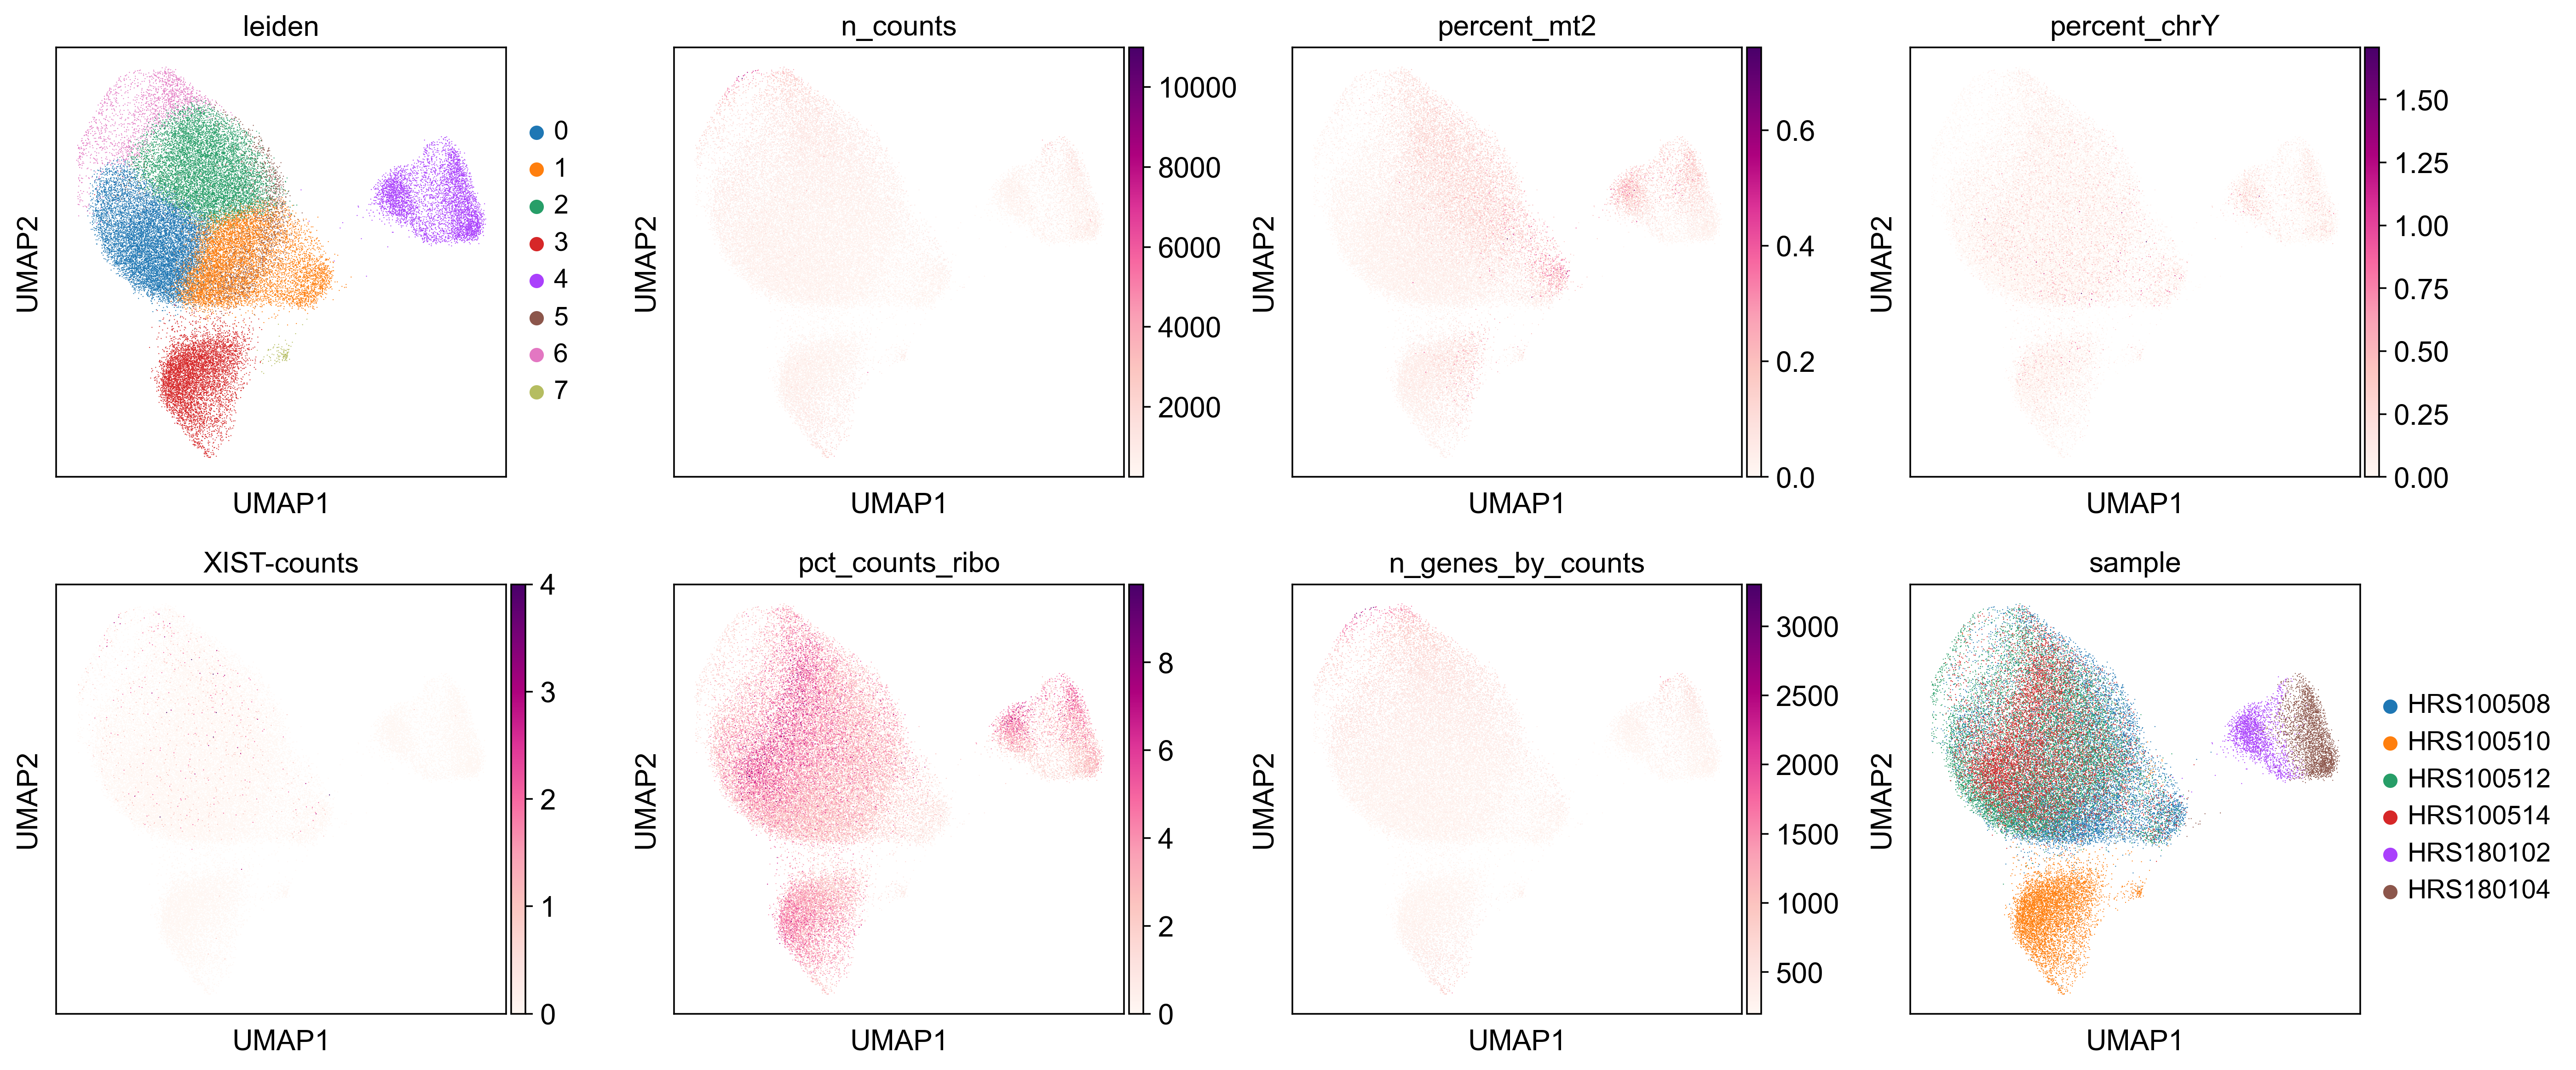

In [18]:
sc.pl.umap(adata, color=[   
    'leiden',  
    'n_counts', 
    'percent_mt2',  
    'percent_chrY', 
    'XIST-counts',  
    'pct_counts_ribo',  
    'n_genes_by_counts', 
    'sample',], size = 1,   
    wspace=0.25)

In [19]:
# Each sample has made it's own cluster, which is batch effect
# choose variety of covariates from obs for panel

/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


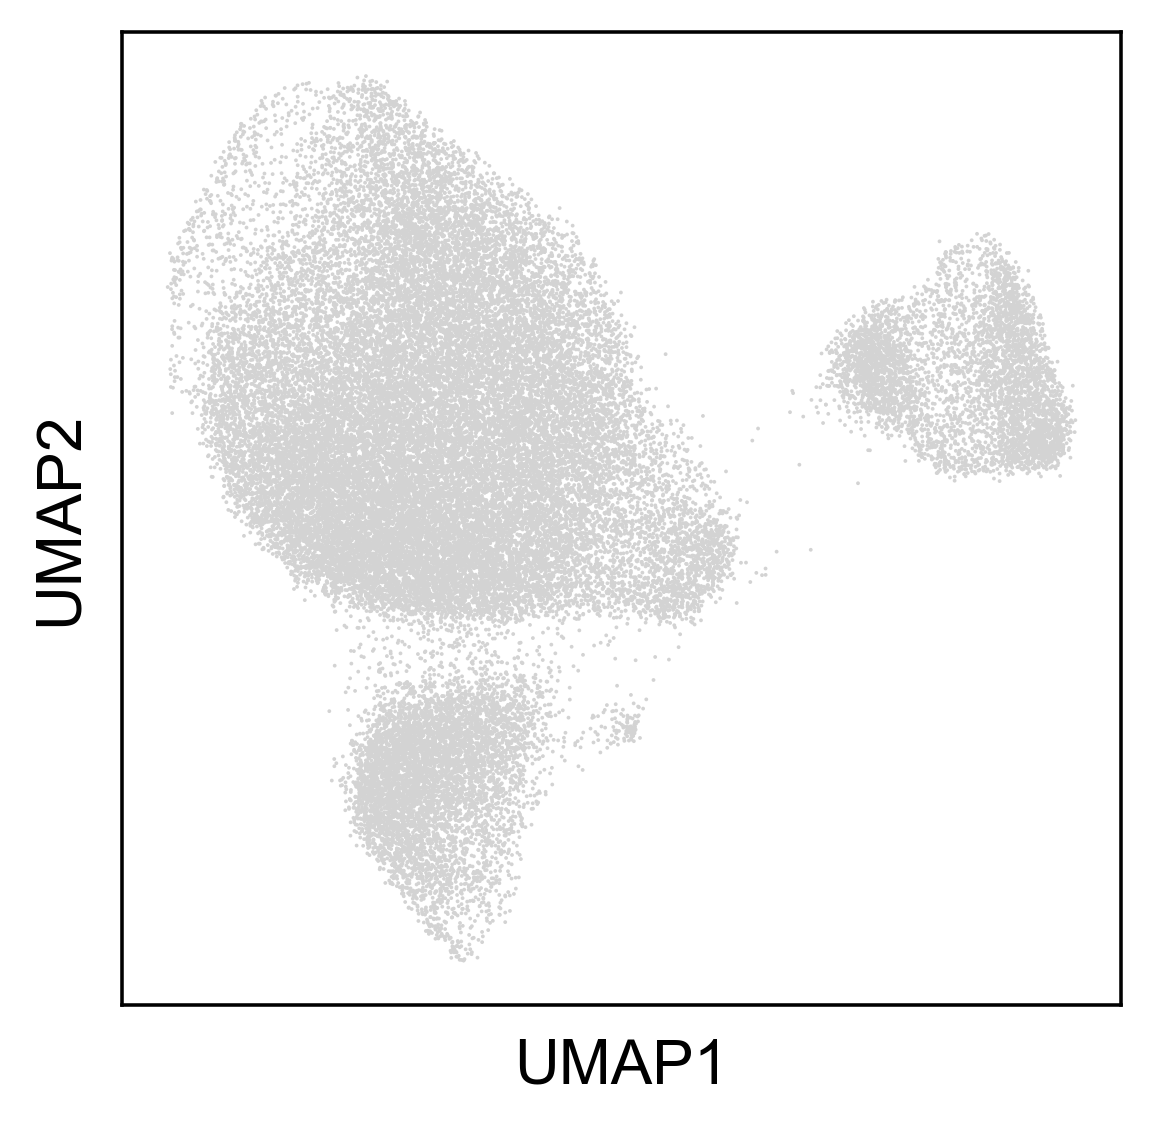

In [20]:
# Now we can use the following code to plot the scaled and corrected gene expression data

sc.pl.umap(adata, use_raw=False, )

### Writing out object


In [21]:
adata.write('/Users/mairi.mcclean/github/data/tb_pbmc_datasets/qc_plus_visualisation/221201_PFMC_CaiY2022_MM_UMAP_v221206.h5ad')
# needs extension .h5ad